<a href="https://colab.research.google.com/github/rodsei/data-science-ifes/blob/main/CIDA_Trabalho_1_Problema_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Previsão em Séries Temporais com LSTM (Long Short-Term Memory)

---

### Conteúdo

1. [Introdução](https://colab.research.google.com/drive/1GzBZEsKzXPYComUD2feOprKexglmQe3r#scrollTo=vLQXQ8pJ3dAD)
2. []()
3. []()
4. []()
5. []()

### Referência

Jason Brownlee. Time Series Forecasting with the Long Short-Term Memory Network in Python. en- US.Abr.de2017.url: https://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/ (acesso em 11/08/2021)

# 1. Introdução

As redes LSTM são redes neurais recorrentes que têm a capacidade de aprender sequências mais longas de observações. Para testar suas capacidades em séries temporais, vamos desenvolver um modelo preditivo com LSTM para um problema de predição univariada de uma etapa.

Ao longo desse *notebook* vamos criar uma linha de base para comparação de desempenho em problemas de predição, elaborar um teste robusto para atender o problema de predição de séries temporais e por fim, preparar os dados, desenvolver o modelo e avaliar os resultados.



# 2. Primeiros passos



Nessa aplicação do LSTM vamos utilizar as ferramentas disponíveis no `scipy`, `keras` do `tensorflow`, `scikit-learn`, `pandas`, `numpy` e `matplotlib`. Primeiramente vamos conhecer a base de dados e e definir os dados de treino e teste para ter uma base inicial de comparação.

## 2.1. Base de Dados

A base utilizada como exemplo registra a quantidade de vendas mensais de shampoo em um período de 3 anos criada por Makridakis, Wheelwright, and Hyndman (1998). Nesse caso, temos um total de 36 registros.

In [206]:
import pandas as pd
from datetime import datetime
database_url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv'
# Transforma os dados do período que estão no formato 1-01
def parser(x):
  # Define um padrão dos anos entre 1991 a 1993
	return datetime.strptime('199'+x, '%Y-%m')

series = pd.read_csv(database_url, parse_dates=['Month'], index_col='Month', squeeze=True, date_parser=parser)
series.head()

Month
1991-01-01    266.0
1991-02-01    145.9
1991-03-01    183.1
1991-04-01    119.3
1991-05-01    180.3
Name: Sales, dtype: float64

Com os dados carregados, podemos visualizar como é o comportamento da série temporal.

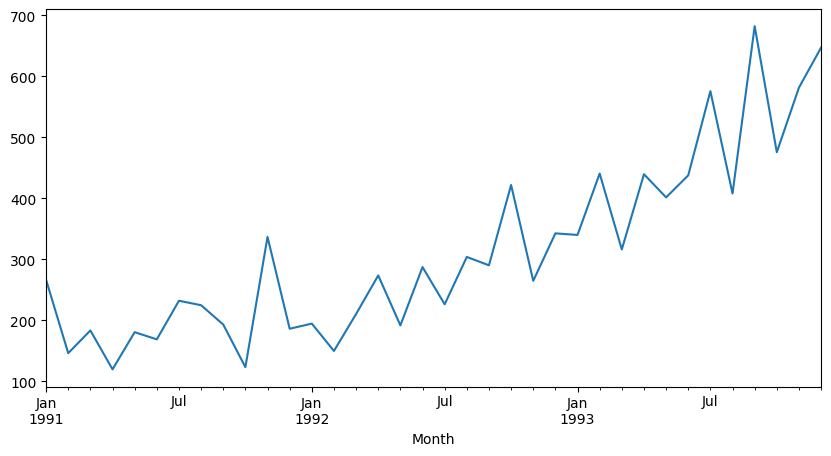

In [207]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5), dpi=100)
series.plot()
plt.show()

## 2.2. Treino e Teste

Assim como o treinamento de qualquer outro modelo, vamos separar a base de dados em duas partes para aplicar o treinamento e os testes. Para as séries temporais, temos uma particularidade nessa etapa, na qual os dados dem ser separados em ordem cronológica, não podem ser aleatórios, por isso iremos definir os intervalos de cada parte.

In [208]:
# Treino e teste
X = series.values
train, test = X[0:-12], X[-12:]

A base de treino contará com os dois primeiros anos, e o treino com o último ano. Os testes serão executados de forma sequencial, avançando em cada período da base de teste e predizendo o valor daquele momento. Em inglês, utiliza-se o nome *walk-forward model validation* para essa abordagem.

In [209]:
# walk-forward model validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
  print(f"Make prediction for test {i}")

Make prediction for test 0
Make prediction for test 1
Make prediction for test 2
Make prediction for test 3
Make prediction for test 4
Make prediction for test 5
Make prediction for test 6
Make prediction for test 7
Make prediction for test 8
Make prediction for test 9
Make prediction for test 10
Make prediction for test 11


Para cada predição realizada para um mês da base de teste, o valor é incorporado ao histórico e disponibilizado para a predição do próximo período. Esse comportamento simula um cenário real, onde as observações da série temporal influenciam no comportamento de predição do próximo mês.

Ao final das predições, os valores serão comparados com os dados reais da base e será calculada a raiz do erro médio quadrático (**RMSE - *Root Mean Squared Error***) para medir a habilidade do modelo.

## 2.3. Base comparativa inicial

A princípio, como não existem pistas de qual o melhor modelo a ser utilizado, normalmente são aplicados métodos de predição simplórios que não exigem muito esforço, assim conseguimos compreender o quanto avançamos com cada modelo.

O modelo de predição adotado inicalmente será o chamado Modelo de Predição Persistente. Esse modelo é uma excelente opção para uma série temporal com tendência linear crescente. Nele utilizamos a observação do momento anterior para predizer o momento atual. O método de predição de forma simples, será assim: `yhat = history[-1]`. Vamos aplicá-lo à base de dados de exemplo utilizando a estrutura criada na seção anterior:

In [210]:
for i in range(len(test)):
	# make prediction
	predictions.append(history[-1])
	# observation
	history.append(test[i])

Após realizar as predições persistentes vamos analisar os resultados utilizando o RMSE.

RMSE: 136.761


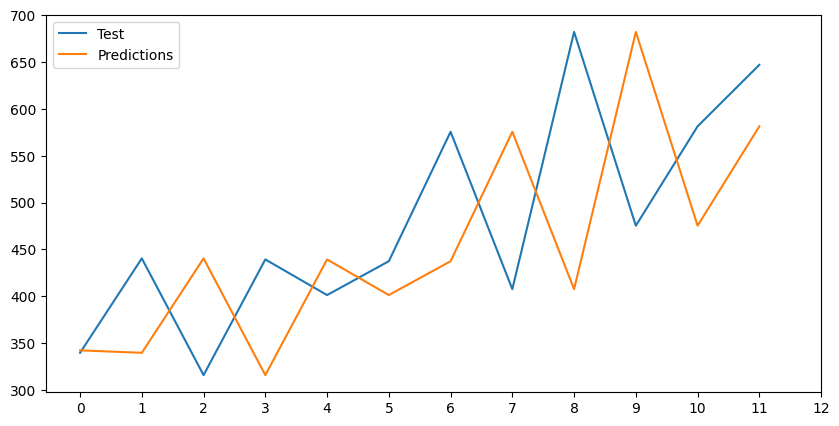

In [211]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

# line plot of observed vs predicted
plt.figure(figsize=(10,5), dpi=100)
plt.plot(test, label='Test')
plt.plot(predictions, label='Predictions')
plt.xticks(range(len(test)+1))
plt.legend()
plt.show()

# 3. Aplicando o modelo LSTM

Com uma base de comparação, já podemos aplicar o modelo mais elaborado. Para utilizar o LSTM, é preciso realizar alguns tratamentos para tornar os dados próprios para realizar o treinamento do modelo. Os detalhes serão apresentados a seguir.

## 3.1. Preparando os dados

A preparação dos dados em uma série temporal tem como objetivo remover ou reduzir algumas propriedades e estados da distribuição que dificultam a etapa de treinamento a encontrar padrões e consequentemente a realizarem predições mais assertivas. Para a base de dados de exemplo, vamos realizar três etapas: 
- Transformar a série em um problema de Aprendizado Supervisionado
- Transformar a série para um estado estacionário
- Transformar as observações para uma escala específica.

### 3.1.1. Série como Aprendizado Supervisionado

Como o modelo LSTM do Keras que vamos utilizar exige que os dados estejam dispostos no formato de um problema de aprendizado supervisionado, ou seja com entrada (X) e saída (y), podemos utilizar um método semelhante ao adotado anteriormente para criar a estrutura esperada. Vamos utilizar a função `shift` do pandas para aplicar o momento `t-1` como entrada e o momento atual `t` como a saída. Esse movimento é definido como um deslocamento na série temporal, em inglês nomeado *lag*.

In [212]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

Com a função de transformação criada, vamos aplicá-la à base de dados e criar uma nova estrutura que será utilizada a partir desse ponto.

In [213]:
supervised = timeseries_to_supervised(X, 1)
print(supervised.head())

       0      0
0    0.0  266.0
1  266.0  145.9
2  145.9  183.1
3  183.1  119.3
4  119.3  180.3


### 3.1.2. Série em estado estacionário

Como pudemos ver no gráfico da série inicialmente, ela possui uma tendência de crescimento e naturalmente ela não é uma série estacionária pois a estrutura dos dados depende do tempo. Uma série pode ser transformada em estacionária removendo a tendência antes das predições e posteriormente adicionando-a novamente nos resultados obtidos, sem prejudicar o comportamento natural dos dados.

Para remover a tendência, vamos aplicar o método de diferenciação, que consiste em subtrair os valores do momento `t-1` do momento `t` e obter uma série com as diferenças entre cada instante, sem a presença da tendência. Para chegar nesse resultado podemos utilizar a função `diff` do pandas ou criar uma função própria para fazer esse processo. Para exemplificar e tornar o processo inverso mais flexível, vamos criar uma função chamada `difference` para criar a série final.

In [214]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

Conforme mencionado anteriormente, vamos criar uma função inversa chamada `inverse_difference` para retomar as predições à sua escala original.

In [215]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

Com as funções de transformação criadas, vamos aplicá-las à base de dados original e validar as duas etapas:

In [216]:
print(f"Original Series:\n{series.head()}\n")
# transform to be stationary
differenced = difference(series, 1)
print(f"Differenced Series:\n{differenced.head()}\n")

# invert transform
inverted = list()
for i in range(len(differenced)):
	value = inverse_difference(series, differenced[i], len(series)-i)
	inverted.append(value)
inverted = pd.Series(inverted)
print(f"Inverted Series:\n{inverted.head()}")

Original Series:
Month
1991-01-01    266.0
1991-02-01    145.9
1991-03-01    183.1
1991-04-01    119.3
1991-05-01    180.3
Name: Sales, dtype: float64

Differenced Series:
0   -120.1
1     37.2
2    -63.8
3     61.0
4    -11.8
dtype: float64

Inverted Series:
0    145.9
1    183.1
2    119.3
3    180.3
4    168.5
dtype: float64


Pode-se notar que na operação inversa, o primeiro valor da série original não está presente, isso acontece pois ele também não está presente na série da diferenciação por não ter um valor prévio para calcular a diferença. Isso ocorre com os primeiros K valores determinados pelo número k de deslocamentos considerados na diferenciação.

### 3.1.3. Observações dentro da escala

Um dos princípios de todas as redes neurais é a sua função de ativação e assim como qualquer outra, o LSTM precisa que os dados estejam dentro da escala dessa função. Por padrão o LSTM utiliza a Tangente Hiperbólica (*tanh*) que varia entre -1 e 1. Por isso vamos aplicar essa escala nos dados da série.

A escala é calculada encontrando os valores mínimo e máximo da série e aplicando nos dados de treinamento. Para isso podemos utilizar a classe `MinMaxScaler`.

In [217]:
from sklearn.preprocessing import MinMaxScaler

def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

Tendo a função definida, podemos verificar o resultado da transformação:

In [218]:
# Format input data
X = series.values
X = X.reshape(len(X), 1)

# Aplly function and verify scaled data
scaler, scaled_X, scaled_y = scale(X[0:-12], X[-12:])
scaled_series = pd.Series(scaled_X[:, 0])
print(scaled_series.head())

0   -0.029441
1   -0.824016
2   -0.577903
3   -1.000000
4   -0.596427
dtype: float64


Assim como a transformação para remover a tendência, vamos precisar do processo inverso para retomar com as predições para a escala original. A seguir podemos confirmar que as duas operações ocorreram normalmente e temos novamente a escala original. Primeiramente vamos criar uma função que realiza a operação inversa:

In [219]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

Com a função criada, podemos testá-la revertendo a escala que foi criada na base de treino. Como essa função será utilizada para reverter a escala dos valores preditos, o parâmetro value será utilizado com o valor escalado (`scaled_X`) da base de treino (`X`).

In [220]:
# Validating inverted scale
inverted_series = list()
for i in range(len(scaled_X)):
  inverted_X = invert_scale(scaler, X[i], scaled_X[i])
  inverted_series.append(inverted_X)
inverted_series = pd.Series(inverted_series)
print(inverted_series.head())

0    266.0
1    145.9
2    183.1
3    119.3
4    180.3
dtype: float64


### 3.1.4. Aplicando todas as transformações

Nas etapas antetiores aplicamos cada transformação individualmente, mas para construir o modelo final, precisamos realizar todas as etapas em conjunto. Para isso vamos aplicálas e preparar a estrutura que será utilizada na próxima seção.

In [221]:
# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

## 3.2. Criando o modelo

### 3.2.1. Características do LSTM

O LSTM é um tipo de rede neural recorrente (RNN), ou seja, pode aprender e lembrar sequências longas de informações e não precisa que uma determinada janela de tempo seja definida. No Keras, essa característica é representada pelo parâmetro `stateful` que deve ser definido como `True` ao se definir uma camada LSTM.

O comportamento padrão da camada LSTM no Keras é manter o estado entre os dados dentro de um lote, definido por um número fixo de linhas da base de treinamento que define quantos padrões serão processados antes de atualizar os pesos da rede neural. Por padrão, o estado entre os lotes na camada LSTM é reiniciado, porém o parâmetro `stateful` nos dá o controle necessário para definir quando o estado da camada LSTM será reiniciado, chamando a função `reset_states`.

A camada LSTM espera receber uma matriz com três dimensões `[Samples, Time Steps, Features]`:
- Samples: observaçõees independentes do domínio, normalmente linhas de dados complementares.
- Time steps: são os indicadores de tempo daos uma variável para uma observação específica.
- Features: outras medidas registradas nos mesmos momentos da observação principal.

Para o exemplo, vamos manter a distribuição dos dados simples considerando cada instante de tempo como na sequencia original, sendo com uma amostra (*Sample*), um momento (*Time Step*) e uma característica (*Feature*). Considerando que os dados de treino possuem X entradas e y saídas, a formatação os dados como esperado pelo Keras ficaria assim:

```
X, y = train[:, 0:-1], train[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])
```

O formato de entrada dos dados no LSTM é definido pelo parâmetro `batch_input_shape` como uma tupla que define o número esperado de observações de cada lote, número de momentos e o número de caracterísrticas. O tamanho do lote normalmente é muito menor que a quantidade total de amostras e em conjunto com o número de épocas, define a velocidade com que a rede aprende sobre os dados, ou seja, a frequência em que os pesos são atualizados.

Por fim, definimo o número de neurõnios, também conhecidos como o número de unidades de memória ou blocos. Para o exemplo, algo em torno de 1 a 5 neurônios será suficiente. Para se criar uma camada única do LSTM, utilizamos o código como apresentado a seguir:

```
layer = LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True)
```

### 3.2.2. Compilando o modelo

Assim que o modelo estiver criado, precisamos utilizar uma biblioteca matemática para compilar a rede neural em uma representação simbólica eficiente. Para isso podemos utlizar o Tensorflow ou Theano. Antes de iniciar a compilação, precisamos definir a funçãode perda e o algoritmo de otimização que serão utilizados no processo. Para o exemplo vamos utilizar, respectivamente, a MSE (*Mean Squared Error*) e o ADAM. A etapa de compilação ficaria assim:

```
model = Sequential()
model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
```

### 3.2.3. Treinando o modelo

Depois que o modelo está compilado, podemos iniciar a etapa de treinamento. Como definimos o modelo como `stateful`, precisamos controlar o treinamento uma época de cada vez até completar a quantidade desejada de épocas. O fim do treinamento de uma época define quando o estado interno será reiniciado.

Normalmente as amostras dentro de uma época são misturadas aleatoriamente, porém, por se tratar de uma série temporal, precisamos que a rede aprenda os padrões de acordo com a sequência original das observações. Sendo assim, vamos utilizar o parâmetro `shuffle` como `False`, assim como o parâmetro `verbose` = 0 para evitar relatórios desnecessários nesse momento. A etapa de treinamento ficará assim:

```
for i in range(nb_epoch):
	model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
	model.reset_states()
```

### 3.2.4. Aplicando todas as etapas de criação

Para simplificar o processo, vamos unificar todas as etapas de criação em uma única função, criando o modelo, compilando e treinando, resultando em um modelo pronto para realizar predições na série temporal. A função está declarada a seguir:

In [222]:
from keras import models, layers

# Create an LSTM network and fit to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = models.Sequential()
	model.add(layers.LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(layers.Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

Com as funções de criação e treinamento em mãos, vamos criar o modelo que será utilizado na próxima seção, utilizando como parâmetros:
- batch_size = 1 
- nb_epoch = 1500
- neurons = 1

In [223]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

## 3.3. Realizando as predições

Com o modelo treinado, já podemos iniciar o processo de predição. Uma vez que temos uma base de teste com os 12 meses do último ano, podemos utilizar duas abordagens de validação do modelo. 

A primeira opção é de realizar todas as previsões de vez, ou seja, as previsões iniciais não atualizam o modelo, nem interferem nas próximas predições à medida que avançamos nos períodos de teste. 

A segunda opção consiste em retreinar o modelo à medida que vamos avançando nas predições, incorporando o valor predito como parte da base de dados de treinamento utilizada anteriormente, ou seja, os valores preditos refinam as próximas predições com a expectativa de gerar predições de acordo com a evolução natural dos dados.

Para exemplificar, vamos utilizar a primeira opção, criando uma função que realiza a predição de um único momento:



In [224]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]  

A função `predict` do modelo retorna uma lista de predições para cada entrada. Como estamos realizando a predição de uma etapa por vez, teremos apenas uma previsão de acordo com a observação do momento anterior. Durante o treinamento, o estado interno é reiniciado à medida que cada época é finalizada, porém durante a predição da série temporal, precisamos manter um estado consistente entre as predições de cada momento, de preferência, atualizando esse estado conforme avançamos nos momentos da base de testes.

Para definir o estado inicial vamos inicializar o estado da rede criando uma predição em todas as amostras da base de treino. Isso irá garantir que poderemos realizar a predição do próximo momento.



In [225]:
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-0.7080187 ],
       [ 0.09284279],
       [-0.5293984 ],
       [ 0.19377765],
       [-0.23164207],
       [ 0.16332981],
       [-0.23581658],
       [ 0.15722254],
       [ 0.03472343],
       [ 0.53044164],
       [-0.8674432 ],
       [-0.00590324],
       [-0.33606476],
       [ 0.30489448],
       [-0.18608075],
       [-0.46067876],
       [ 0.19999674],
       [-0.59144795],
       [ 0.32737705],
       [-0.21619035],
       [ 0.02456108],
       [-0.8725623 ],
       [ 0.24011096]], dtype=float32)

Com esse estado interno criado previamente, podemos iniciar as predições na base de testes, avançando em um momento por vez, até o fim do último ano:

In [226]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=313.928293, Expected=339.700000
Month=2, Predicted=365.666447, Expected=440.400000
Month=3, Predicted=329.665075, Expected=315.900000
Month=4, Predicted=416.169281, Expected=439.300000
Month=5, Predicted=432.522027, Expected=401.300000
Month=6, Predicted=444.150712, Expected=437.400000
Month=7, Predicted=396.574827, Expected=575.500000
Month=8, Predicted=403.282696, Expected=407.600000
Month=9, Predicted=513.146810, Expected=682.000000
Month=10, Predicted=529.061765, Expected=475.300000
Month=11, Predicted=369.121674, Expected=581.300000
Month=12, Predicted=359.693661, Expected=646.900000


Após realizar as predições, podemos avaliar o resultado e compará-lo com nossa base inicial:

Test RMSE: 128.756


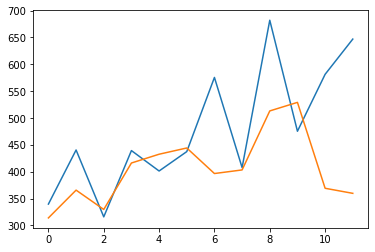

In [227]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.plot(raw_values[-12:])
plt.plot(predictions)
plt.show()


O modelo criado chegou a um resultado um pouco melhor que a base inicial, com um RMSE de 128 contra 136. Para os exemplos, alguns métodos que poderiam aperfeiçoar ainda mais o modelo, não foram utilizados para manter as explicações mais simples. Para alcançar um modelo mais robusto, é preciso realizar uma otimização dos parâmetros, retreinar o modelo à medida que avançamos nas predições, e executar uma série de predições para avaliar a estabilidade do modelo, conhecendo assim o seu desempenho mais realista.